In [1]:
import os

from dvclive import Live
from dvclive.lightning import DVCLiveLogger
import numpy as np
import pytorch_lightning as pl
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder_size=64, lr=1e-3):
        super().__init__()

        # Saves any args passed to __init__ (for example, encoder_size)
        self.save_hyperparameters()

        self.encoder = nn.Sequential(nn.Linear(28 * 28, encoder_size), nn.ReLU(), nn.Linear(encoder_size, 3))
        self.decoder = nn.Sequential(nn.Linear(3, encoder_size), nn.ReLU(), nn.Linear(encoder_size, 28 * 28))

        self.lr = 1e-3

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [3]:
# setup data
dataset = MNIST(os.getcwd(), download=True, transform=ToTensor())
train_loader = utils.data.DataLoader(dataset)

# DVC Report

params.yaml

|   encoder_size |    lr |
|----------------|-------|
|             64 | 0.001 |

metrics.json

|   train.loss |   epoch |   step |
|--------------|---------|--------|
|    0.0561632 |       4 |    999 |

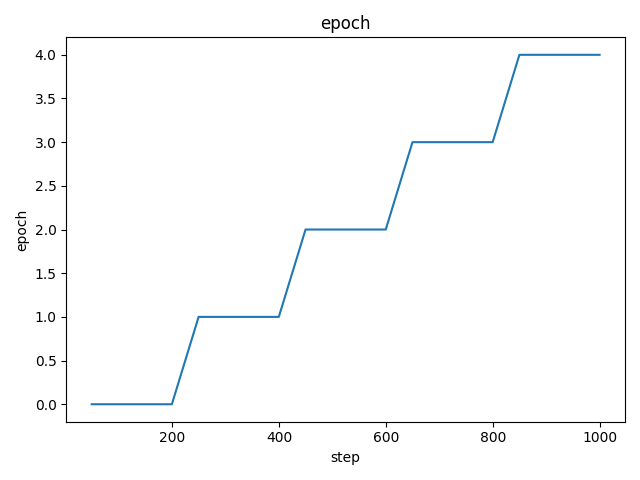

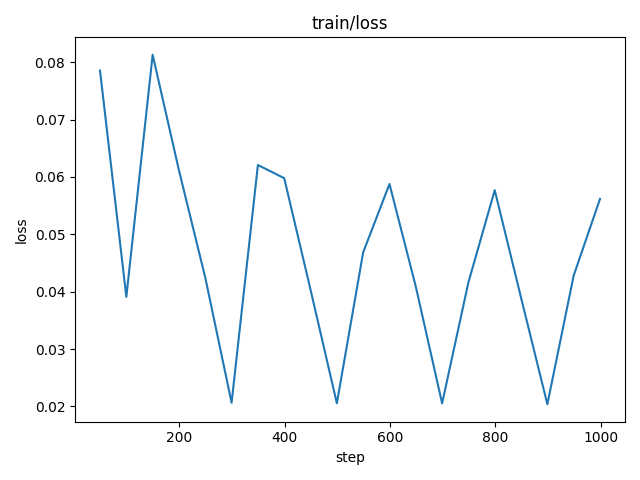


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 51.74it/s, loss=0.0501, v_num=_run]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 51.60it/s, loss=0.0501, v_num=_run]


In [9]:
# train the model
autoencoder = LitAutoEncoder(encoder_size=64, lr=1e-3)
trainer = pl.Trainer(
    limit_train_batches=200,
    max_epochs=5,
    logger=DVCLiveLogger(save_dvc_exp=True, report="notebook"),
)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

In [10]:
import pandas as pd
from dvc.api import exp_show

pd.DataFrame(exp_show())

,Experiment,rev,typ,Created,parent,State,Executor,train.loss,epoch,step,encoder_size,lr
0,None,workspace,baseline,None,None,None,None,0.056163,4.0,999.0,64.0,0.001
1,None,main,baseline,"Apr 28, 2023",None,None,None,0.056488,4.0,999.0,64.0,None
2,adunc-soja,2c232c6,branch_commit,03:04 PM,None,None,None,0.056163,4.0,999.0,64.0,0.001
3,conic-keys,5c2dad6,branch_commit,03:03 PM,None,None,None,0.056009,4.0,999.0,64.0,0.0001
4,ahull-chin,c28afc1,branch_base,03:03 PM,None,None,None,0.058970,4.0,999.0,64.0,0.01
